In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec


LOCATION_PROCESSED = 'data_processed'
LOCATION_SURVEY = f'{LOCATION_PROCESSED}/survey_responses.csv'
LOCATION_QUESTIONS = f'{LOCATION_PROCESSED}/questions_processed.csv'

In [2]:
# load the survey data
survey = pd.read_csv(LOCATION_SURVEY, index_col=0)
survey.head()

,1,2,3,4,5,6,7,8,9,10,...,52,53,54,55,56,57,58,59,60,61
0,18-24,Male,Denmark,Undergraduate,Finance / Accounting,Once every three months,Strongly disagree,Agree,Neither agree nor disagree,Food and Beverages,...,No,2.0,Maybe,3.0,No,1.0,Yes,4.0,No,3.0
1,25-34,Female,United States,Part-time Employee,Other,Once every three months,Agree,Strongly agree,Agree,Toys and Games|Books and Media,...,Maybe,3.0,Yes,5.0,Yes,1.0,Yes,1.0,No,3.0
2,25-34,Male,Denmark,Unemployed,Technology / IT,Rarely / Never,Strongly disagree,Strongly disagree,Strongly disagree,NaN,...,Yes,5.0,Maybe,3.0,Yes,5.0,No,3.0,No,3.0
3,25-34,Male,Denmark,Graduate / Postgraduate,Technology / IT,Once a month,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Electronics and Gadgets|Toys and Games|Health ...,...,No,3.0,Maybe,3.0,Maybe,2.0,Maybe,2.0,No,3.0
4,25-34,Male,Finland,Undergraduate,Finance / Accounting,Once every three months,Disagree,Agree,Agree,Electronics and Gadgets|Clothing and Accessories,...,Yes,4.0,No,3.0,Yes,4.0,Maybe,3.0,No,3.0


In [3]:
# load questions
df_questions = pd.read_csv(LOCATION_QUESTIONS, index_col=0)

# Get all column names of df_questions
column_names = df_questions.columns.tolist()

# Filter questions where the index is 20 or above
strategy_questions = df_questions[df_questions.index >= 20]

In [4]:
strategy_questions_copy = strategy_questions.copy()
""" 
strategy_questions_copy.loc[:, 'no_data'] = np.nan
strategy_questions_copy.loc[:, 'yes_data'] = np.nan """

strategy_answers = []

for i in range(21):
    yes_no_q = 12 + (i * 2)
    rating_q = 13 + (i * 2)
    survey.iloc[:, [yes_no_q, rating_q]]

    no_responses = survey[survey.iloc[:, yes_no_q].isin(['No', 'Maybe'])]
    flattened_no_responses = no_responses.iloc[:, rating_q].dropna().values.flatten()

    yes_responses = survey[survey.iloc[:, yes_no_q] == 'Yes']
    flattened_yes_responses = yes_responses.iloc[:, rating_q].dropna().values.flatten()

    q = strategy_questions[strategy_questions.index == 20 + i*2]

    strategy_answers.append({
        'yes': flattened_yes_responses,
        'no': flattened_no_responses,
        "strategy": q['strategy'].values[0],
        "shortStrategy": q['shortStrategy'].values[0],
        "taxonomicalParentIndex": q['taxonomicalParentIndex'].values[0],
        "taxonomicalParent": q['taxonomicalParent'].values[0],
        "strategy_index": i + 1,
    })


# Add empty columns to category_groups_questions

""" category_groups = [
    ['Beauty', 'Air Pollution'],                # Group 1: 2 categories
    ['Running Ground', 'Noise Levels', 'Crowds'],  # Group 2: 3 categories
    ['Traffic', 'Safety', 'Obstacles'],         # Group 3: 3 categories
    ['Category 1', 'Category 2'],              # Group 4: 2 categories
    ['X', 'Y', 'Z', 'W'],                      # Group 5: 4 categories
    ['A', 'B', 'C'],                           # Group 6: 3 categories
] """


strategy_answers_df = pd.DataFrame(strategy_answers)
grouped_strategy_answers_df = strategy_answers_df.groupby('taxonomicalParentIndex')
category_groups_index = grouped_strategy_answers_df['strategy_index'].apply(list)
# Swap the order of the last two groups, so that only groups of 2 or less is on the left side of the graph
category_groups_index.iloc[4], category_groups_index.iloc[5] = category_groups_index.iloc[5], category_groups_index.iloc[4] 


category_groups = category_groups_index.apply(lambda x: [strategy_answers_df.loc[strategy_answers_df['strategy_index'] == idx, 'shortStrategy'].values[0] for idx in x])
no_data = category_groups_index.apply(lambda x: [strategy_answers_df.loc[strategy_answers_df['strategy_index'] == idx, 'no'].values[0] for idx in x])
yes_data = category_groups_index.apply(lambda x: [strategy_answers_df.loc[strategy_answers_df['strategy_index'] == idx, 'yes'].values[0] for idx in x])

# Create a map from taxonomicalParentIndex to taxonomicalParent
taxonomical_parent_map = strategy_answers_df.set_index('taxonomicalParentIndex')['taxonomicalParent'].to_dict()
taxonomical_parent_map[4], taxonomical_parent_map[5] = taxonomical_parent_map[5], taxonomical_parent_map[4] 

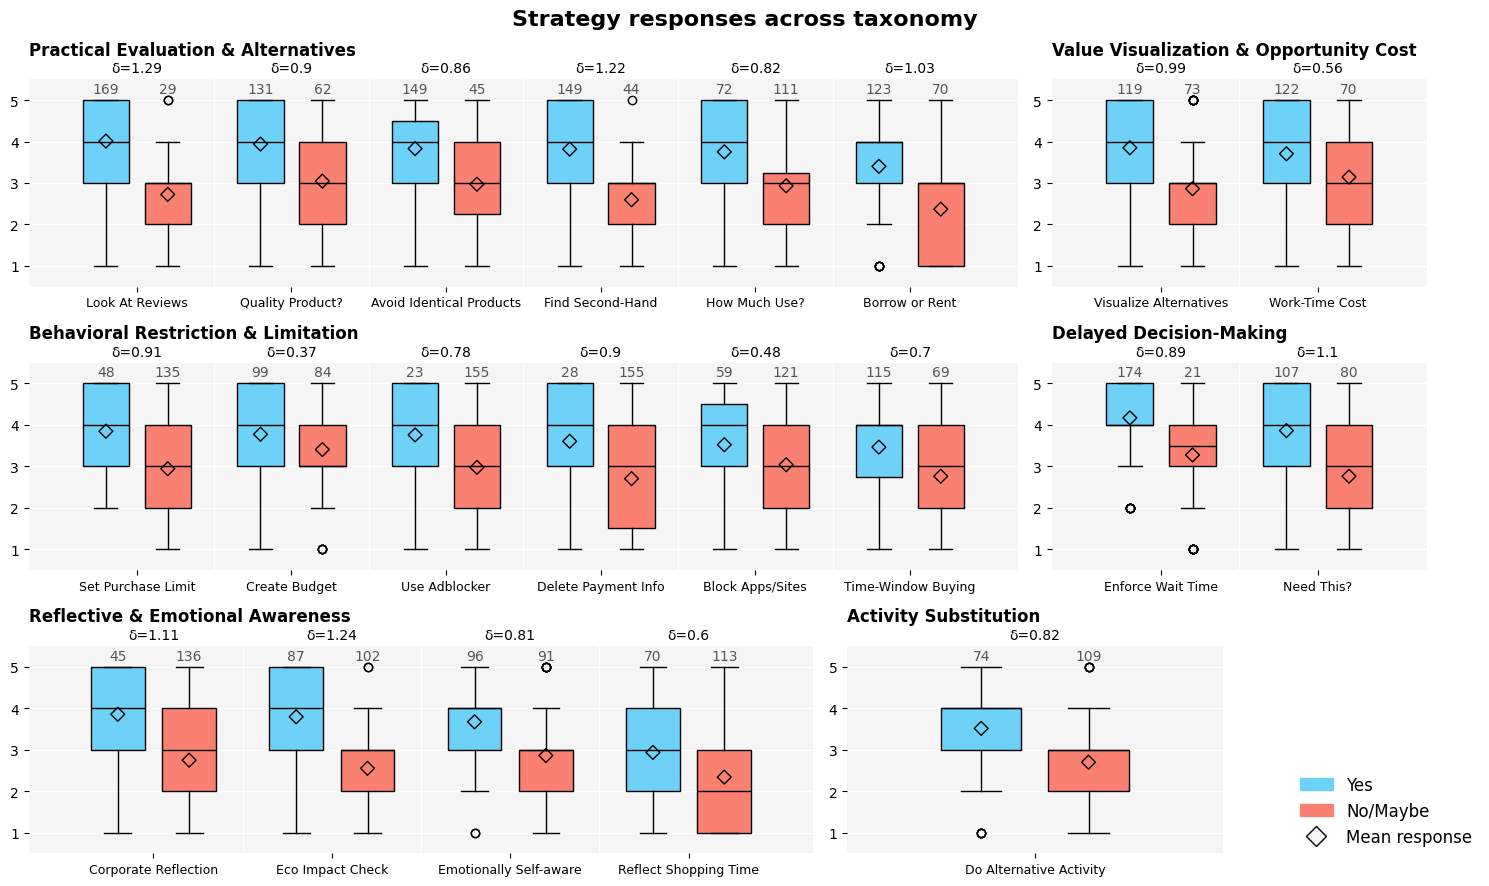

In [5]:

# Create a figure with GridSpec
fig = plt.figure(figsize=(15, 9))
# Define the layout using subplot2grid
size = (3,7)
ax4 = plt.subplot2grid(size, (0, 0), colspan=5) #Practical Evaluation 6
ax6 = plt.subplot2grid(size, (0, 5), colspan=2) #Value viz 2
ax1 = plt.subplot2grid(size, (1, 0), colspan=5) #Behaviour restriction 6
ax2 = plt.subplot2grid(size, (1, 5), colspan=2) #Delay Decision 2
ax3 = plt.subplot2grid(size, (2, 0), colspan=4) #Reflective 4
ax5 = plt.subplot2grid(size, (2, 4), colspan=2) #Activity sub 1

axes = [ax1, ax2, ax3, ax4, ax5, ax6]


# Colors for the clusters
colors = ['#6ED1F8', 'salmon']

mean_data = [];

# Iterate through category groups and add a subplot for each
for i, (categories, yes_data_row, no_data_row) in enumerate(zip(category_groups, yes_data, no_data)):
    ax = axes[i]  # Use the predefined axes
    cluster1_data = yes_data_row[:len(categories)]
    cluster2_data = no_data_row[:len(categories)]
    
    # Add diamonds for the means
    means_cluster1 = [np.mean(data) for data in cluster1_data]
    means_cluster2 = [np.mean(data) for data in cluster2_data]
    yes_count = [len(data) for data in cluster1_data]
    mean_data.append(list(zip(categories, means_cluster1, means_cluster2, yes_count)))

    combined_for_sorting = list(zip(categories, cluster1_data, cluster2_data, means_cluster1, means_cluster2))
    combined_sorted = sorted(combined_for_sorting, key=lambda x: x[3], reverse=True)
    categories, cluster1_data, cluster2_data, means_cluster1, means_cluster2 = zip(*combined_sorted)

    # Define positions for boxplots within each category
    offset_from_middle = 0.2
    positions_cluster1 = [x - offset_from_middle for x in range(len(categories))]
    positions_cluster2 = [x + offset_from_middle for x in range(len(categories))]

    # Plot Cluster 1
    ax.boxplot(
        cluster1_data,
        positions=positions_cluster1,
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=colors[0], color='black'),
        medianprops=dict(color='black'),
    )

    # Plot Cluster 2
    ax.boxplot(
        cluster2_data,
        positions=positions_cluster2,
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=colors[1], color='black'),
        medianprops=dict(color='black'),
    )

    # For Cluster 1
    ax.scatter(
        positions_cluster1, means_cluster1, 
        facecolors='none', edgecolors='black', 
        marker='D', s=50, zorder=5
    )

    # For Cluster 2
    ax.scatter(
        positions_cluster2, means_cluster2, 
        facecolors='none', edgecolors='black', 
        marker='D', s=50, zorder=5
    )

    # Add vertical white lines to separate categories
    for x in range(len(categories) - 1):
        ax.axvline(x=x + 0.5, color='white', linewidth=1)

    # Add top-title for each category
    for j, category in enumerate(categories):
        y_max = 5.1  # Adjusted height for the text placement
        ax.text(
            x=j - offset_from_middle, y=y_max, s=f"{len(yes_data_row[j])}", ha='center', va='bottom',
            fontsize=10, color="#555"
        )
        ax.text(
            x=j + offset_from_middle, y=y_max, s=f"{len(no_data_row[j])}", ha='center', va='bottom',
            fontsize=10, color="#555"
        )

        diff = round((means_cluster1[j] - means_cluster2[j]), 2)
        ax.text(
            x=j, y=5.6, s=f"δ={diff}", ha='center', va='bottom',
            fontsize=10, color="black"
        )
        


    ax.text(
            x=-0.70, y=6, s=taxonomical_parent_map[i], ha='left', va='bottom',
            fontsize=12, color='black', weight="bold"
        )

    # Customize axes
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, fontsize=9)
    ax.set_yticks(np.arange(1, 6, 1))
    ax.set_ylim(0.5, 5.5)
    ax.grid(color='white', linewidth=1, axis='y', alpha=1)
    ax.set_facecolor('#F5F5F5')

    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

from matplotlib.patches import Patch

# Add legend
handles = [
    Patch(color=colors[0], label='Yes'),
    Patch(color=colors[1], label='No/Maybe'),
    plt.Line2D([0], [0], marker='D', color='black', label='Mean response', markerfacecolor='#F5F5F5', markersize=10,  linestyle='None')
]
legend = fig.legend(handles=handles, loc='lower right', fontsize=12, bbox_to_anchor=(0.995, 0.033))
legend.get_frame().set_edgecolor('none')  # Remove outline


# Adjust layout
fig.suptitle('Strategy responses across taxonomy', fontsize=16, weight='bold')
plt.tight_layout()  # Leave space for title
plt.show()

# Save the plot as a PNG file
fig.savefig('./plots/strategy_responses_across_taxonomy.png', dpi=300)


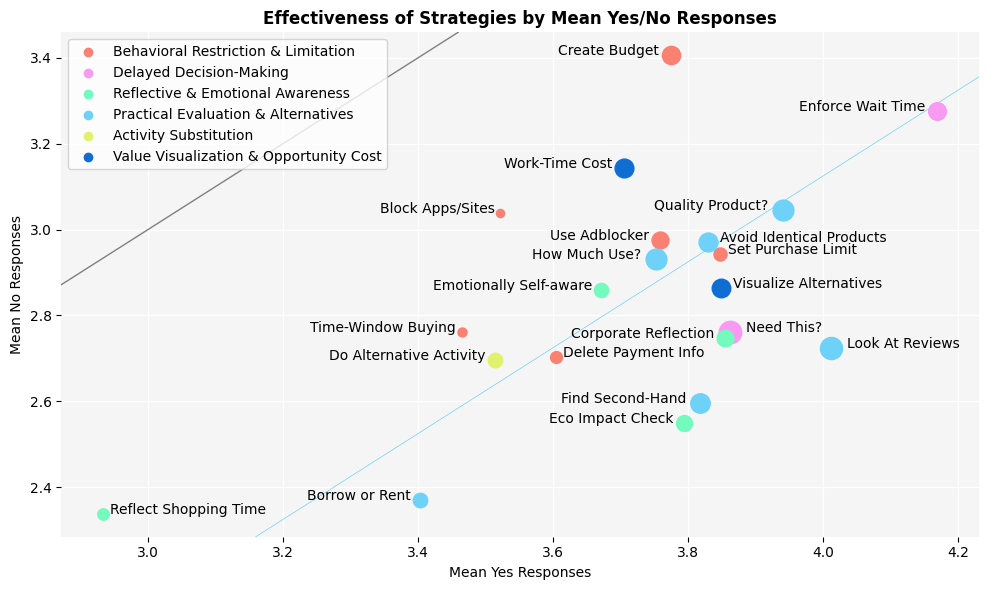

0.8748491878503285


In [6]:
flattened_mean_data = [item for sublist in mean_data for item in sublist]

# Calculate mean difference from yes to no
mean_diff = [entry[1] - entry[2] for entry in flattened_mean_data]
mean_diff = np.mean(mean_diff)


move_to_right = ["Set Purchase Limit", "Reflect Shopping Time", "Avoid Identical Products", "Look At Reviews", "Need This?", "Delete Payment Info", "Visualize Alternatives"]
# Create a scatter plot
fig = plt.figure(figsize=(10, 6))


colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D',  '#106ED3']

plt.axline([3, 3], [3.1, 3.1], color='gray', linewidth=1)
plt.axline([3+mean_diff, 3], [3.1+mean_diff, 3.1], color='#6ED1F8', linewidth=0.5)
for (i, group) in enumerate(mean_data):
    color = colors[i]
    for entry in group:
        plt.scatter(entry[1], entry[2], color=color, s=entry[3]*1.5, zorder=2)
        if entry[0] in move_to_right:
            plt.text(entry[1] + 0.006 + entry[3]/10000, entry[2], entry[0], fontsize=10, ha='left')
        else:
            plt.text(entry[1] - 0.006 - entry[3]/10000, entry[2], entry[0], fontsize=10, ha='right')

    legend_label = taxonomical_parent_map[i]
    plt.scatter([], [], color=color, label=legend_label)
    l = plt.legend(loc='upper left')


# Clean up spines

ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xlabel('Mean Yes Responses')
plt.ylabel('Mean No Responses')
plt.title('Effectiveness of Strategies by Mean Yes/No Responses', fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the plot as a PNG file
fig.savefig('./plots/strategy_responses_scatter.png', dpi=300)
print(mean_diff)

In [7]:
import matplotlib.colors as mcolors

def darken_color(color, amount=0.3):
    """
    Darkens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgb(c)
    return mcolors.to_hex([max(0, min(1, 1 - (1 - x) * amount)) for x in c])

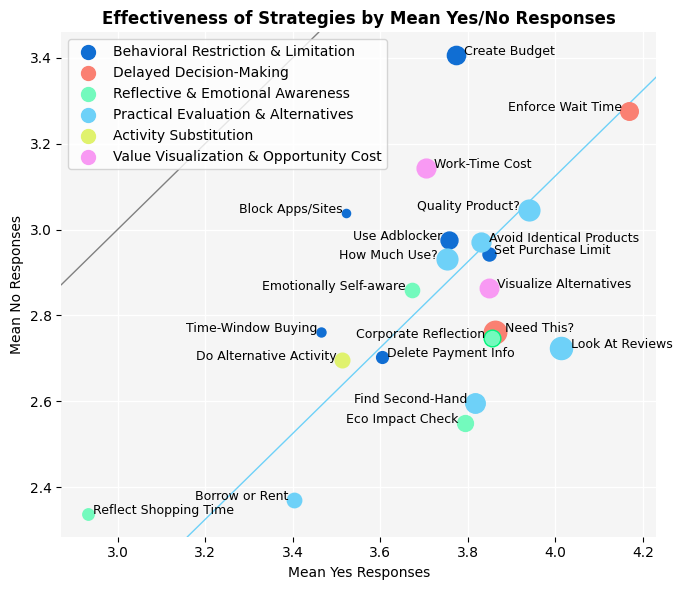

In [14]:
flattened_mean_data = [item for sublist in mean_data for item in sublist]

# Calculate mean difference from yes to no
mean_diff = [entry[1] - entry[2] for entry in flattened_mean_data]
mean_diff = np.mean(mean_diff)


move_to_right = ["Set Purchase Limit", "Reflect Shopping Time", "Avoid Identical Products", "Look At Reviews", "Need This?", "Delete Payment Info", "Visualize Alternatives", "Work-Time Cost", "Create Budget"]
# Create a scatter plot
fig = plt.figure(figsize=(7, 6))


colors = ['#106ED3', '#FA8072', '#73FABD', '#6ED1F8','#E0F26D', '#F899F3']
darkened_colors = [darken_color(color, 2) for color in colors]

plt.axline([3, 3], [3.1, 3.1], color='gray', linewidth=1)
plt.axline([3+mean_diff, 3], [3.1+mean_diff, 3.1], color='#6ED1F8', linewidth=1)
for (i, group) in enumerate(mean_data):
    color = colors[i]
    for entry in group:
        if entry[0] in ["Corporate Reflection"]:
            plt.scatter(entry[1], entry[2], color=color, s=entry[3]*1.5, zorder=2, edgecolors=darkened_colors[i], linewidths=1)
        else:
            plt.scatter(entry[1], entry[2], color=color, s=entry[3]*1.5, zorder=2)

        if entry[0] in move_to_right:
            plt.text(entry[1] + 0.006 + entry[3]/10000, entry[2], entry[0], fontsize=9, ha='left')
        else:
            plt.text(entry[1] - 0.006 - entry[3]/10000, entry[2], entry[0], fontsize=9, ha='right')

    legend_label = taxonomical_parent_map[i]
    plt.scatter([], [], color=color, label=legend_label, s=100)

plt.legend(loc='upper left')

# Clean up spines

ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xlabel('Mean Yes Responses')
plt.ylabel('Mean No Responses')
plt.title('Effectiveness of Strategies by Mean Yes/No Responses', fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the plot as a PNG file
fig.savefig('./plots/strategy_responses_scatter.png', dpi=300)

In [9]:
strategy_questions_copy = strategy_questions.copy()
""" 
strategy_questions_copy.loc[:, 'no_data'] = np.nan
strategy_questions_copy.loc[:, 'yes_data'] = np.nan """

strategy_answers = []

for i in range(21):
    yes_no_q = 12 + (i * 2)
    rating_q = 13 + (i * 2)
    survey.iloc[:, [yes_no_q, rating_q]]

    no_responses = survey[survey.iloc[:, yes_no_q] == 'No']
    flattened_no_responses = no_responses.iloc[:, rating_q].dropna().values.flatten()

    maybe_responses = survey[survey.iloc[:, yes_no_q] == 'Maybe']
    flattened_maybe_responses = maybe_responses.iloc[:, rating_q].dropna().values.flatten()

    yes_responses = survey[survey.iloc[:, yes_no_q] == 'Yes']
    flattened_yes_responses = yes_responses.iloc[:, rating_q].dropna().values.flatten()

    q = strategy_questions[strategy_questions.index == 20 + i*2]

    strategy_answers.append({
        'yes': flattened_yes_responses,
        'maybe': flattened_maybe_responses,
        'no': flattened_no_responses,
        "strategy": q['strategy'].values[0],
        "shortStrategy": q['shortStrategy'].values[0],
        "taxonomicalParentIndex": q['taxonomicalParentIndex'].values[0],
        "taxonomicalParent": q['taxonomicalParent'].values[0],
        "strategy_index": i + 1,
    })


strategy_answers_df = pd.DataFrame(strategy_answers)
grouped_strategy_answers_df = strategy_answers_df.groupby('taxonomicalParentIndex')
category_groups_index = grouped_strategy_answers_df['strategy_index'].apply(list)
# Swap the order of the last two groups, so that only groups of 2 or less is on the left side of the graph
category_groups_index.iloc[4], category_groups_index.iloc[5] = category_groups_index.iloc[5], category_groups_index.iloc[4] 


category_groups = category_groups_index.apply(lambda x: [strategy_answers_df.loc[strategy_answers_df['strategy_index'] == idx, 'shortStrategy'].values[0] for idx in x])
no_data = category_groups_index.apply(lambda x: [strategy_answers_df.loc[strategy_answers_df['strategy_index'] == idx, 'no'].values[0] for idx in x])
yes_data = category_groups_index.apply(lambda x: [strategy_answers_df.loc[strategy_answers_df['strategy_index'] == idx, 'yes'].values[0] for idx in x])
maybe_data = category_groups_index.apply(lambda x: [strategy_answers_df.loc[strategy_answers_df['strategy_index'] == idx, 'maybe'].values[0] for idx in x])

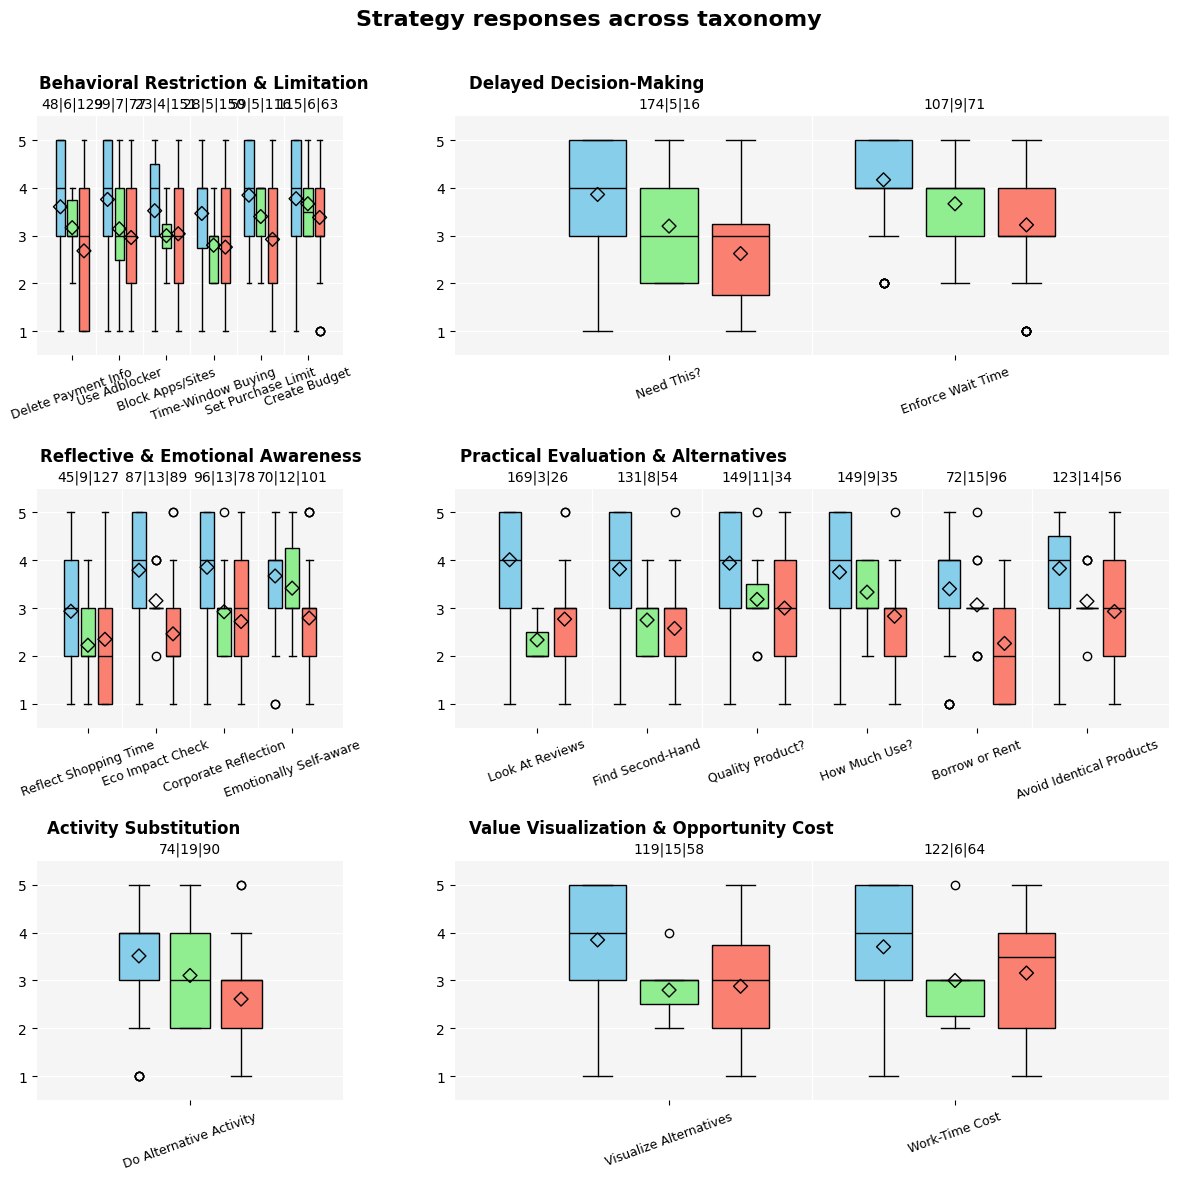

In [10]:
# Create a figure with GridSpec
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(3, 2, figure=fig, width_ratios=[0.3,0.7])  # 3 rows, 2 columns layout

# Colors for the clusters
colors = ['skyblue', 'lightgreen', 'salmon']

# Iterate through category groups and add a subplot for each
for i, (categories, yes_data_row, no_data_row, maybe_data_row) in enumerate(zip(category_groups, yes_data, no_data, maybe_data)):
    ax = fig.add_subplot(gs[i // 2, i % 2])  # Determine position in the grid
    cluster1_data = yes_data_row[:len(categories)]
    cluster2_data = maybe_data_row[:len(categories)]
    cluster3_data = no_data_row[:len(categories)]

    # Define positions for boxplots within each category
    positions_cluster1 = [x - 0.25 for x in range(len(categories))]
    positions_cluster2 = [x for x in range(len(categories))]
    positions_cluster3 = [x + 0.25 for x in range(len(categories))]

    # Plot Cluster 1
    ax.boxplot(
        cluster1_data,
        positions=positions_cluster1,
        widths=0.2,
        patch_artist=True,
        boxprops=dict(facecolor=colors[0], color='black'),
        medianprops=dict(color='black'),
    )

    # Plot Cluster 2
    ax.boxplot(
        cluster2_data,
        positions=positions_cluster2,
        widths=0.2,
        patch_artist=True,
        boxprops=dict(facecolor=colors[1], color='black'),
        medianprops=dict(color='black'),
    )


    # Plot Cluster 2
    ax.boxplot(
        cluster3_data,
        positions=positions_cluster3,
        widths=0.2,
        patch_artist=True,
        boxprops=dict(facecolor=colors[2], color='black'),
        medianprops=dict(color='black'),
    )

    # Add diamonds for the means
    means_cluster1 = [np.mean(data) for data in cluster1_data]
    means_cluster2 = [np.mean(data) for data in cluster2_data]
    means_cluster3 = [np.mean(data) for data in cluster3_data]

    # For Cluster 1
    ax.scatter(
        positions_cluster1, means_cluster1, 
        facecolors='none', edgecolors='black', 
        marker='D', s=50, zorder=5
    )

    # For Cluster 2
    ax.scatter(
        positions_cluster2, means_cluster2, 
        facecolors='none', edgecolors='black', 
        marker='D', s=50, zorder=5
    )

    # For Cluster 2
    ax.scatter(
        positions_cluster3, means_cluster3, 
        facecolors='none', edgecolors='black', 
        marker='D', s=50, zorder=5
    )

    # Add vertical white lines to separate categories
    for x in range(len(categories) - 1):
        ax.axvline(x=x + 0.5, color='white', linewidth=1)

    # Add top-title for each category
    for j, category in enumerate(categories):
        y_max = 5.6  # Adjusted height for the text placement
        title = f"{len(yes_data_row[j])}|{len(maybe_data_row[j])}|{len(no_data_row[j])}" 
        ax.text(
            x=j, y=y_max, s=title, ha='center', va='bottom',
            fontsize=10, color='black'
        )

    ax.text(
            x=-0.70, y=6, s=taxonomical_parent_map[i], ha='left', va='bottom',
            fontsize=12, color='black', weight="bold"
        )

    # Customize axes
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, fontsize=9, rotation=20)
    ax.set_yticks(np.arange(1, 6, 1))
    ax.set_ylim(0.5, 5.5)
    ax.grid(color='white', linewidth=1, axis='y', alpha=1)
    ax.set_facecolor('#F5F5F5')

    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Adjust layout
fig.suptitle('Strategy responses across taxonomy', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for title
plt.show()